In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit.extensions import XGate
from ibm_washington_config import coupling_map, basis_gates
from ionq_config import coupling_map, basis_gates

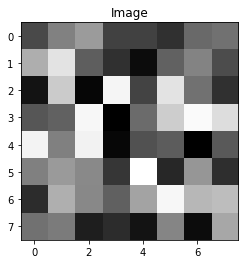

In [2]:
image = np.random.uniform(low=0, high=255, size=(8,8)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

sort pixels

In [3]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [4]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

In [5]:
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    # qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 111  | 4 | 512| 261|
| 4  | 1983  | 6 | 11765| 4888|
| 8  | 32511  | 8 | 194961| 81016|
| 16  | 523263  | 10 | ||
| 32  | 8382466  | 12|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

In [6]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 32386, # of qubits is 8


In [21]:
wash_qc = transpile(circuits=qc_image, coupling_map=coupling_map, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
# wash_qc.draw()

depth is 81016


In [7]:
# qc_image.draw()

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=100000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

the meauserd colors are 
 [ 78 128 152  68  70  49 103 116 172 220  97  58  18 101 134  78  22 203
  11 245  73 225 116  54  87  98 250   5 107 203 256 220 244 126 241   8
  80  93   0  89 126 155 135  58 256  45 150  52  45 174 137  98 165 250
 178 186 110 121  37  47  18 134  17 168] 
 the input colors are 
 [ 76 129 155  67  67  50 106 114 173 225  95  51  15  99 132  78  22 202
   9 243  69 226 114  51  87  98 245   3 108 204 248 219 242 128 240  10
  84  93   3  91 128 154 137  56 253  42 150  48  47 174 136  97 164 245
 182 188 115 124  33  47  22 133  15 167]
the meauserd coordinates are 
 [ 0  0  1  3  4  5  5  6  7  9  9 11 10 13 14 15 14 17 17 18 19 21 21 22
 24 24 26 26 28 29 29 29 32 32 33 35 35 37 37 40 40 40 43 41 43 43 46 47
 48 49 49 50 51 52 53 54 54 56 59 60 61 60 61 61]


As we can see above, probabilistic amplitude <ins>coordinate</ins> encoding fails

In [9]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

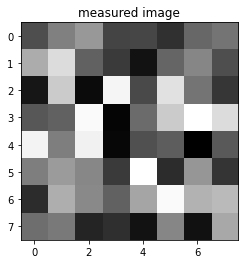

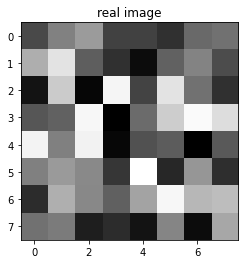

In [10]:
plot_to_compare(output_im, image)